# Nanoimage Classification with CapsNet
Deep learning is a great approach that can help us to do fantastic AI based processes and develop our models. The base element of models implemented by deep learning is a neuron, as well as neural networks are usual and effective method for building and developing state-of-the-art models.
Most solved problem in machine learining is classification problem, however since in deep learning we work with visual data, neurons will be brought up to acheive the solution. Neurons are game changer but not efficeint enough to help us in some hard situations. Although we have worked with nanoimage classification task with implementing convolutional neural networks, we couldn't reach to our satisfaction point. This can be resulted due to below causes:
- ConvNets are good at detecting whole presence of image but, they are poor at act correctly with element change in the input.
- Due to maxpooling layers, they are invariant to orientational variation.
- They can't learn sufficiently relationships between data elments. For example in the picture below, a ConvNet think both images the same.
- They must be fed at training with high quantity of data. That is the most important problem that we deal with.
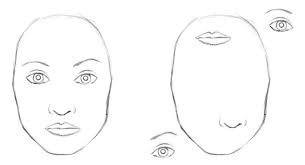

# Overall Structure of CapsNets
The structure shown as below, at first we have ConvNets that detect general representations of inputs. Then we have primary caps that are capsules connected to each other with dynamic routing. The next part includes in labels caps (digits caps for mnist data) capsules that carry labels. Finally we have a decoder network for reconstruction of data to involve it in evaluation.
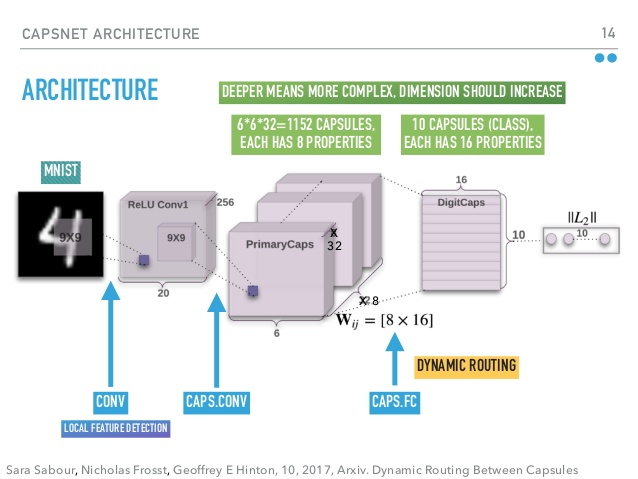

We have concatenated CNT and SEM nanoimages and labels to more generalize the model. Below are candidates for the input images.
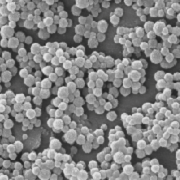 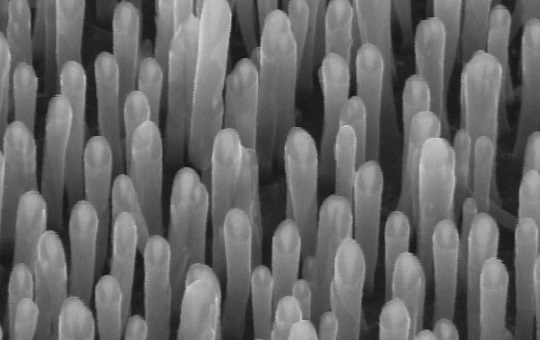

Therefore we do the hierarchy written as codes below.

In [24]:
# Import Libraries
import numpy as np
import pandas as pd
import keras
import cv2
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout 
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import initializers
from keras import models
from keras.preprocessing import image
from keras.engine.topology import Layer
from keras import regularizers
# Adjusting Import Directory
cwd = os.getcwd()
os.chdir("C:/Users/toranj/Desktop/DL Python")

In [20]:
'''
Predefined Functions:
Sharpen : To sharpen the image using "unsharp mask" method. 
'''
# Sharpfactor is an int betweeen 0 and 1 determines how much high the result is to be sharpened.
def sharpen(img,sharpfactor):
    threshold = 0.5
    blurred = cv2.GaussianBlur(img,ksize = (3,3),sigmaX=0)
    masked = np.abs(img - blurred) < threshold
    image = cv2.addWeighted(blurred, -sharpfactor, img , (1+sharpfactor), gamma = 0)
    binmasked = masked.astype(bool)
    image = image * (binmasked.astype(image.dtype))
    return image

def Clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(image)
    return img


def Load_data(mode):
    a = {'GrayScale':0, 'Color':None}
    image_path1 = "C:/Users/toranj/Desktop/DL Python/CNT/"                       # path of train images
    image_path2 = "C:/Users/toranj/Desktop/DL Python/SEM of Nanoparticles/"
    images = glob.glob(image_path1 +"*.jpg") + glob.glob(image_path2 +"*.png")   # selecting images
    images.sort()                                                                # sorting images
    final_images=[] 
    for img in images:    
        image = cv2.imread(img,a[mode])                    # loading images
        image = cv2.resize(image,(500,300))                # Resizing images
        image = image / np.max(image)                      # Normalization
       #image = Clahe(image)                               # Adaptive Histogram Equlization
        image = sharpen(image,0.8)                         # Sharpening
        image = image.tolist()
        final_images.append(image)
    return final_images

def Load_labels():
    labels = pd.read_excel("CNT Labels.xlsx")
    final_labels = labels.values.tolist()
    return final_labels

def ConvNet(In):
    shape = (len(In[1]),len(In[2]),len(In[3]))
    inlay = Input(shape = shape)
    C1 = Conv2D(40,3, activation = 'relu', padding = 'same',kernel_regularizer = None, input_shape =shape)(inlay)
    C2 = Conv2D(80,3,activation = 'relu', padding = 'same',kernel_regularizer = None)(C1)
    
    return C2

def squash(vectors, axis= 1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors
def mul_on_batch(A,B,batch1,batch2):
    for i in batch1:
        for j in batch2:
            O = np.matmul(A[i][j], B[i][j])
    return O
        
def PrimaryCap(Input, capdim, channels = 32):
    number_of_filters = capdim*channels
    ksize = (3,3)
    stride = 2
    padding = 'valid'
    Conv1 = layers.Conv2D(number_of_filters, ksize, strides = stride, padding = padding)(Input)
    Output = layers.Reshape(target_shape = [-1,capdim])(Conv1)
    Final = layers.Lambda(squash)(Output)
    return Final
    

In [25]:
def BuildModel():
    CNT_Model = Sequential()
    
    reg = regularizers.l1_l2(l1 = 0.001, l2 = 0.002)
    
    CNT_Model.add(Conv2D(20,5, activation = 'relu',strides=3, padding = 'same',kernel_regularizer = None, input_shape =(300,500,1)))
    CNT_Model.add(Conv2D(20,5, activation = 'relu',strides=2, padding = 'same', kernel_regularizer = None))
    CNT_Model.add(MaxPooling2D(pool_size = (2,2)))
    CNT_Model.add(Dropout(0.8))
    CNT_Model.add(Conv2D(40,5, activation = 'relu', padding = 'same', kernel_regularizer = reg))
    CNT_Model.add(MaxPooling2D(pool_size = (2,2)))
    CNT_Model.add(Conv2D(40,5, activation = 'relu', padding = 'same', kernel_regularizer = reg))
    CNT_Model.add(Dropout(0.5))
    CNT_Model.add(Flatten())
    CNT_Model.add(Dense(15,activation = 'relu', kernel_regularizer = None))       
    CNT_Model.add(Dropout(0.5))
    #CNT_Model.add(BatchNormalization())
    CNT_Model.add(Dense(8,activation = 'relu', kernel_regularizer = None))
    #CNT_Model.add(BatchNormalization())
    CNT_Model.add(Dense(3,activation='softmax'))

    Optimizer = keras.optimizers.SGD(lr=0.01, momentum = 0.5, decay = 1e-5, nesterov = True)
   
    CNT_Model.compile(optimizer=Optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return CNT_Model
CNT_Model = BuildModel()
CNT_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 167, 20)      520       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 84, 20)        10020     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 42, 20)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 42, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 42, 40)        20040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 21, 40)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 21, 40)        40040     
__________

# ConvNet Evaluation
First of all, we visualize what convnets learn. We should carry edge detectors to the capsule, so that we want to ensure convnet work properly.

In [26]:
#Load Data for Convnet Evaluation
nim = 1
X = Load_data(mode = 'GrayScale')
X[nim] = np.reshape(X[nim], [1,300,500,1])

In [55]:
Model = BuildModel()
layer_outputs = [layer.output for layer in Model.layers[:8]]
activation_model = models.Model(inputs=Model.input, outputs=layer_outputs)
activations = activation_model.predict(X[nim])
first_layer_activation = activations[6]

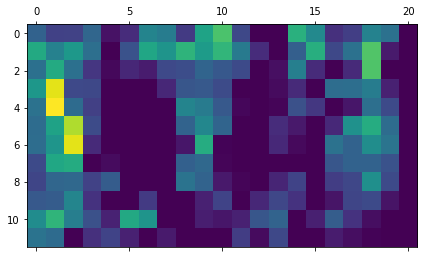

In [61]:
plt.matshow(first_layer_activation[0, :, :,30], cmap='viridis')

# Creating Capsule Network

In [40]:
#Capsule Layers
class CapsLayer(Layer):
    def __init__(self,capdim ,capnum, routestep, kernel_initializer='glorot_uniform', **kwargs):
        self.capdim = capdim
        self.capnum = capnum
        self.routestep = routestep
        self.kernel_initializer = initializers.get(kernel_initializer)
        super(CapsLayer,self).__init__(**kwargs)
    
    def build(self,inputshape):
        self.invecdim = inputshape[0]
        self.invecnum = inputshape[1]
        
        # compute transform W
        self.W = self.add_weight(name = 'transform matrix', shape =[self.capnum, self.invecnum, self.capdim, self.invecdim],
                                 initializer = self.kernel_initializer)
        super(CapsLayer,self).create(inputshape)
    
    def call(self, xinput, train = None):
        xexpand = K.expand_dims(xinput,1)
        xtile =  np.tile(xexpand,[1,1,capnum,1])
    
        capinput = mul_on_batch(xtile,self.W,capnum,invecnum)
        
        #dynamic routing
        B = np.zeros([capinput[0], capnum, invecnum])
        C = np.zeros([capinput[0], capnum, invecnum])
        for k in range(self.routestep):
            capmid = mul_on_batch(C,capinput,C[0],C[1])
            capout = squash(capmid)
            if k < self.routestep -1:
                capout = mul_on_batch(capmid,capinput,capmid[0],capmid[1])
                capout += capout
        return capout
    def compute_output_shape(self,inputshape):
        return tuple([None,self.capnum,self.capdim])

In [6]:
class ReplacewithLength(Layer):
    def __init__(self, capout):
        self.capout = capout
        super(ReplacewithLength,self).__init__(**kwargs)
    def call(self):
        RWLOut = np.sqrt(np.sum(np.square(self.capout), -1))
        return RWLOut
    def compute_output_shape(self,inputshape):
        return inputshape[:-1]

class LabelMask(Layer):
    def __init__(self,inputs):
        maskin = self.inputs
        super(LabelMask,self).__init__(**kwargs)
    def call(self, inputs, **kwargs):
        if (not np.shape(maskin) == 2) and (maskin is list): 
            MaskOut,maskin = maskin
        else:
            length = np.sqrt(np.sum(np.square(maskin), -1))
            Out = K.one_hot(indices = np.argmax(length,1), num_classes = length.get_shape().as_list()[1])
            MaskedOut = K.batch_flatten(maskin * K.expand_dims(mask, -1))
        return Maskedout
    def compute_output_shape(self,inputshape):
        if type(inputshape[0]) is tuple:  
            return tuple([None, inputshape[0][1] * inputshape[0][2]])
        else:
            return ([None, inputshape[1] * inputshape[2]])
        

In [41]:
#Encoder
In = Load_data(mode = 'GrayScale')
Conv1 = ConvNet(In)
PC = PrimaryCap(Conv1, capdim = 8, channels = 32)
CL = CapsLayer(capdim = 16, capnum = 5 , routestep = 6)(PC)
RwL = ReplacewithLength()(CL)
LM = LabelMask()(RwL)
CapEncoder = Model(In,LM)
CapEncoder.summary()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'